In [1]:
import utils
import pandas as pd
import plotly.express as px
from umap import UMAP

In [2]:
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

In [3]:
# Read all the plates

all_plates_df = pd.DataFrame()
for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query("Perturbation==@modality")
    for cell in modality_df.Cell_type.unique():
        cell_df = modality_df.query('Cell_type==@cell')
        for time_point in cell_df.Time.unique():
            time_df = cell_df.query("Time==@time_point")
            for plate in time_df.Assay_Plate_Barcode.unique():
                data_df = (
                    utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                    .assign(Metadata_modality=modality)
                    .assign(Metadata_cell=cell)
                    .assign(Metadata_time=utils.time_point(modality, time_point))
                )
                all_plates_df = utils.concat_profiles(all_plates_df, data_df)

all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

In [4]:
# UMAP

X = utils.get_featuredata(all_plates_df)

umap_2d = UMAP(n_components=2, random_state=9000)
projection_2d = umap_2d.fit_transform(X)

time_list = list(all_plates_df.Metadata_time)
cell_list = list(all_plates_df.Metadata_cell)
modality_list = list(all_plates_df.Metadata_modality)

X_embedded_df = pd.DataFrame({'Modality': modality_list,
                              'time': time_list,
                              'Cell': cell_list,
                              'umap 1': projection_2d[:,:1].flatten(),
                              'umap 2': projection_2d[:,1:2].flatten()})


In [5]:
X_embedded_df = (
    X_embedded_df.sample(frac=1).reset_index(drop=True)
    .replace({'compound':'Compound',
              'crispr':'CRISPR',
              'orf':'ORF'})
)

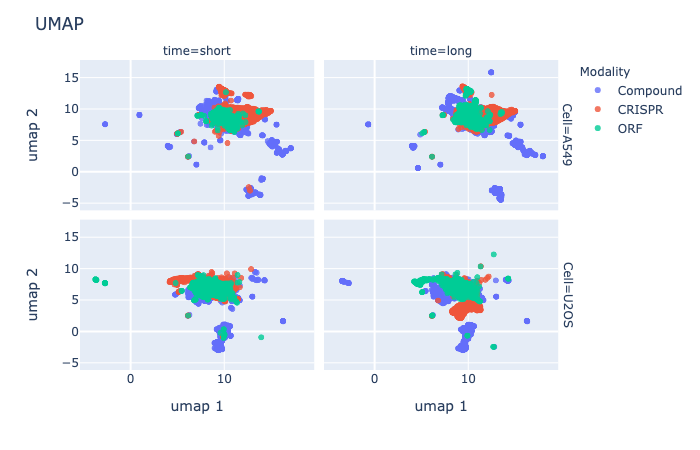

In [6]:
fig = px.scatter(data_frame=X_embedded_df,
                 x='umap 1',
                 y='umap 2',
                 color='Modality',
                 facet_col='time',
                 facet_row='Cell',
                 opacity=0.8,
                 category_orders={"Cell": ["A549", "U2OS"],
                                  "time": ["short", "long"],
                                  "Modality": ["Compound", "CRISPR", "ORF"]})
fig.update_layout(title='UMAP')
fig.show("png")
fig.write_image(f'figures/4.umap.png', width=640, height=480, scale=2)